In [1]:
import sys; sys.path.append('/rds/general/user/cb2714/home/'); from wwa import *

### **IOD**

In [49]:
# download CVDP data (about 16gb in total so download to ephemeral space)
# !wget http://webext.cgd.ucar.edu/Multi-Case/CVDP_repository/cmip5.rcp85/cmip5.rcp85.cvdp_data.tar
# !wget http://webext.cgd.ucar.edu/Multi-Case/CVDP_repository/cmip5.historical/cmip5.historical.cvdp_data.tar
# !wget http://webext.cgd.ucar.edu/Multi-Case/CVDP_repository/cmip6.hist_ssp585/cmip6.hist_ssp585.cvdp_data.tar

URL transformed to HTTPS due to an HSTS policy
--2023-11-29 11:44:45--  https://webext.cgd.ucar.edu/Multi-Case/CVDP_repository/cmip6.hist_ssp585/cmip6.hist_ssp585.cvdp_data.tar
Resolving webext.cgd.ucar.edu (webext.cgd.ucar.edu)... 2a0c:5bc0:4c:ff::8075:d36, 128.117.13.54
Connecting to webext.cgd.ucar.edu (webext.cgd.ucar.edu)|2a0c:5bc0:4c:ff::8075:d36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9013452800 (8.4G) [application/x-tar]
Saving to: ‘cmip6.hist_ssp585.cvdp_data.tar’

cmip6.hist_ssp585.c 100%[===================>]   8.39G  6.22MB/s    in 32m 19s 

2023-11-29 12:17:05 (4.43 MB/s) - ‘cmip6.hist_ssp585.cvdp_data.tar’ saved [9013452800/9013452800]



In [126]:
# unpack
# !tar -xf cmip5.rcp85.cvdp_data.tar
# !tar -xf cmip5.historical.cvdp_data.tar
# !tar -xf cmip6.hist_ssp585.cvdp_data.tar

!mv *cvdp_data*.nc ../00_WWA_project_folder/ephemeral/cvdp/cmip6

In [73]:
# !mv ../00_WWA_project_folder/ephemeral/cvdp/cmip5/*.tar .

## **Extract IOD for available models**

In [181]:
seas = "son"; m = 11

### **CMIP5**

In [188]:
clist = glob.glob("../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/cordex/rx3day-dat/*.dat")
gcms = list(set(["_".join(fnm.split("_")[6:8]) for fnm in clist]))
gcms = ['NorESM1-M_1',  'GFDL-ESM2G_1', 'IPSL-CM5A-LR_1', 'HadGEM2-ES_1', 'MIROC5_1',
         'CanESM2_1', 'EC-EARTH_12', 'EC-EARTH_2', 'EC-EARTH_3', 'MPI-ESM-MR_1',
         'CNRM-CM5_1', 'MPI-ESM-LR_1']

iod_ds = []
for gcm in gcms:    
    
    fl = glob.glob("../00_WWA_project_folder/ephemeral/cvdp/cmip5/"+gcm+"*.nc")
    if len(fl) == 0: continue
        
    ds = [decode_times(xr.open_dataset(fnm, decode_times = False)) for fnm in fl]
    if not "indian_ocean_dipole" in ds[0].variables: continue
        
    iod = xr.concat([da.indian_ocean_dipole for da in ds], "time").rename("iod")
    
    iod = iod.rolling(time = 3).mean().groupby("time.month")[m]
    iod = iod.assign_coords(time = iod.time.dt.year).rename("year")
    
    # specify filename
    csv_fnm = "ts/iod-"+seas+"_cvdp_cmip5_"+gcm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+seas.upper()+" mean of Indian Ocean Dipole - "+gcm+" - Horn of Africa flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# iod [degC] IOD (downloaded from https://www2.cesm.ucar.edu/working_groups/CVC/cvdp/data-repository.html) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year iod"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    iod.to_pandas().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **CMIP6**

In [187]:
clist = glob.glob("../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/*.dat")
clist = sorted([re.sub(".dat", "", fnm.split("_")[-1])+"_r1i1p1f1" for fnm in clist])

for gcm in clist:    
    
    if gcm in ["FGOALS-g3_r1i1p1f1"]: continue
    
    fl = glob.glob("../00_WWA_project_folder/ephemeral/cvdp/cmip6/"+gcm+"*.nc")
    if len(fl) == 0: continue
    print(fl[0], len(fl))
    
    ds = decode_times(xr.open_dataset(fl[0], decode_times = False))
    if not "indian_ocean_dipole" in ds.variables: continue
    
    iod = ds.indian_ocean_dipole
    iod = iod.rolling(time = 3).mean().groupby("time.month")[m]
    iod = iod.assign_coords(time = iod.time.dt.year).rename("year")
    
    # specify filename
    csv_fnm = "ts/iod-"+seas+"_cvdp_cmip6_"+gcm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+seas.upper()+" mean of Indian Ocean Dipole - "+gcm+" - Horn of Africa flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# iod [degC] IOD (downloaded from https://www2.cesm.ucar.edu/working_groups/CVC/cvdp/data-repository.html) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year iod"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    iod.to_pandas().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

../00_WWA_project_folder/ephemeral/cvdp/cmip6/ACCESS-CM2_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/ACCESS-ESM1-5_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/AWI-CM-1-1-MR_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/BCC-CSM2-MR_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/CESM2-WACCM_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/CESM2_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/CMCC-CM2-SR5_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/CMCC-ESM2_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/CanESM5_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/EC-Earth3-CC_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/EC-Earth3-Veg-LR_r1i1p1f1.cvdp_data.1900-

### **HighResMIP**

In [184]:
clist = glob.glob("../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/HighResMIP/rx3day-dat/*.dat")
clist = sorted([re.sub(".dat", "", fnm.split("_")[-1])+"_r1i1p1f1" for fnm in clist])

for gcm in clist:    
    
    if gcm in ["FGOALS-g3+_r1i1p1f1"]: continue
    
    fl = glob.glob("../00_WWA_project_folder/ephemeral/cvdp/cmip6/"+gcm+"*.nc")
    if len(fl) == 0: continue
    print(fl[0], len(fl))
    
    ds = decode_times(xr.open_dataset(fl[0], decode_times = False))
    if not "indian_ocean_dipole" in ds.variables: continue
    
    iod = ds.indian_ocean_dipole
    iod = iod.rolling(time = 3).mean().groupby("time.month")[m]
    iod = iod.assign_coords(time = iod.time.dt.year).rename("year")
    
    # specify filename
    csv_fnm = "ts/iod-"+seas+"_cvdp_highresmip_"+gcm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("! Filename too long: ", csv_fnm)

    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: "+seas.upper()+" mean of Indian Ocean Dipole - "+gcm+" - Horn of Africa flooding 2023, c.barnes22@imperial.ac.uk"
    str2 = "# iod [degC] IOD (downloaded from https://www2.cesm.ucar.edu/working_groups/CVC/cvdp/data-repository.html) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year iod"

    # make .dat file
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    iod.to_pandas().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

../00_WWA_project_folder/ephemeral/cvdp/cmip6/FGOALS-f3-L_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/IPSL-CM6A-LR_r1i1p1f1.cvdp_data.1900-2100.nc 1
../00_WWA_project_folder/ephemeral/cvdp/cmip6/MPI-ESM1-2-HR_r1i1p1f1.cvdp_data.1900-2100.nc 1


## **Check IOD quality**

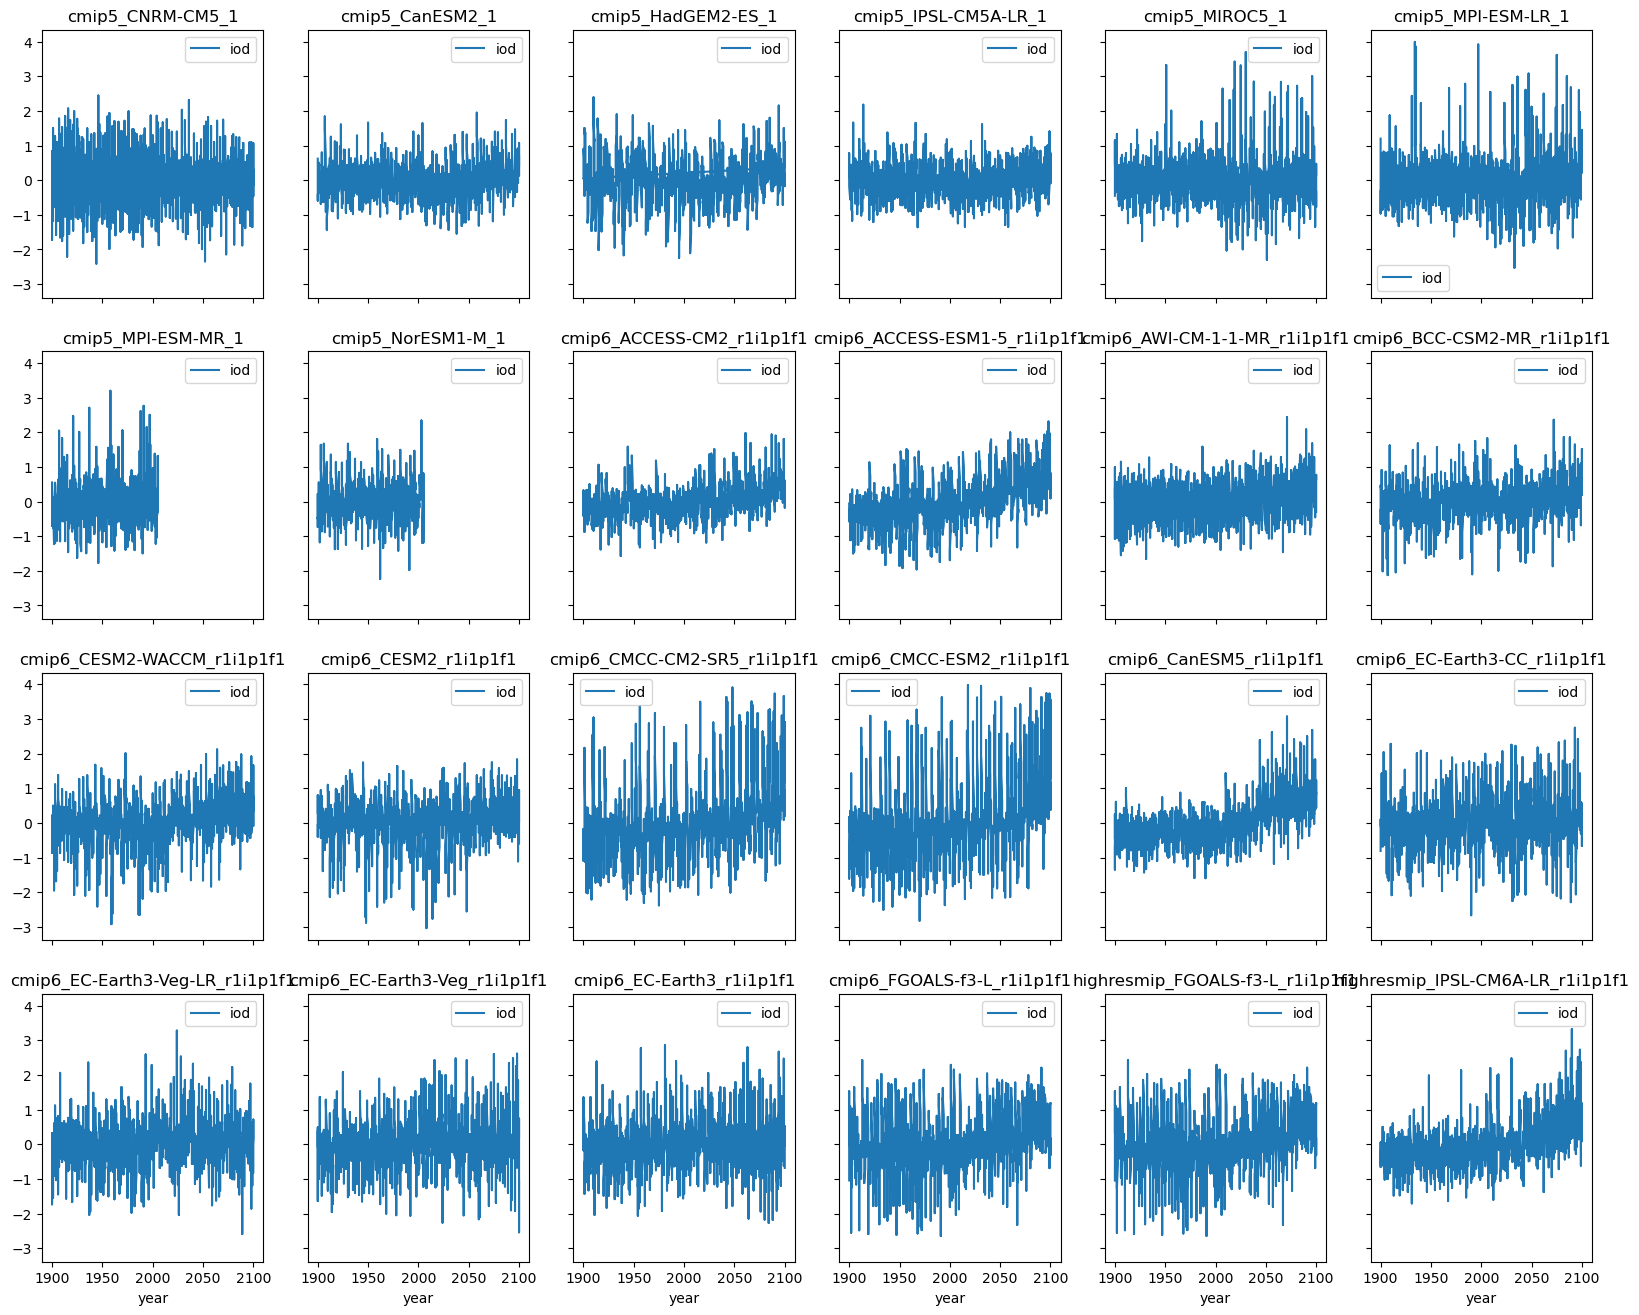

In [183]:
fl = sorted(glob.glob("ts/iod-cvdp_*"))  ## actually daily data, but mislabelled with years only
fig, axs = plt.subplots(ncols = 6, nrows = 4, figsize = (20,16), sharex = True, sharey = True)

for i in range(24):
    
    ts = pd.read_csv(fl[i], comment = "#", sep = " ", header = None, names = ["year", "iod"], index_col = 0)
    ts.plot(ax = fig.axes[i])
    fig.axes[i].set_title(re.sub(".dat", "", re.sub(".+cvdp_", "", fl[i])))

In [190]:
clist = glob.glob("../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/cordex/rx3day-dat/*.dat")

In [194]:
gcms = sorted(list(set(["_".join(fnm.split("_")[6:8]) for fnm in clist])))

In [196]:
glob.glob("../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/*.dat")

['../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_FGOALS-g3.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_CESM2-WACCM.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_CanESM5-1.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_MPI-ESM-1-2-HAM.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_MPI-ESM1-2-LR.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_GISS-E2-2-G.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/timeseries/CMIP6/rx3day-dat/rx3day-ond_HoA_CMCC-ESM2.dat',
 '../00_WWA_project_folder/ephemeral/ModelSimulations-EastAfricaFloods/times